<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/%E5%8A%A0%E5%85%A5IBP_EBP%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install catboost
from google.colab import drive
drive.mount('/content/drive')
from sklearn.multioutput import MultiOutputRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import warnings;warnings.simplefilter('ignore')
from sklearn.model_selection import cross_validate
from sklearn.linear_model import BayesianRidge, LinearRegression,Lasso,Ridge
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics.scorer import make_scorer
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def mape(a, b):
    a ,b = np.array(a) ,np.array(b)
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()

def rmse(y_t,y_p):
  return np.sqrt(mean_squared_error(y_t,y_p))

def metric(y_t,y_p,name):
  res = {'R2':np.clip(r2_score(y_t,y_p),0,1),
         'RMSE':rmse(y_t,y_p),
         'MAPE':mape(y_t,y_p)}
  return pd.DataFrame(res,index=[name])

def clean(df):
  condition = (df['N+A'] >= 36)
  return df.loc[condition]

def std_filter(df,num,cols=None):
  if cols == None:
    cols = df.columns
  for col in cols:
    ub = df[col].median() + num*df[col].std()
    lb = df[col].median() - num*df[col].std()
    df = df[(df[col] > lb)&(df[col] < ub)]
  df = df.dropna()
  return df

def get_result(y_test,y_pred):
  res = pd.DataFrame()
  for y_name in y_columns:
    row = metric(y_test[y_name],y_pred[y_name],y_name)
    res = res.append(row)
  res.loc['AVG'] = res.mean()
  return res

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def rule3(df):
  error_idx = []
  for idx in tqdm(df.index):
    row = df.loc[idx]
    if 'IBP' in df.columns.tolist():
      c1 = (row['IBP']<row['T10'])&(row['T10']<row['T50'])&(row['T50']<row['T90'])&(row['T90']<row['EBP'])
    else:
      c1 = (row['T10']<row['T50'])&(row['T50']<row['T90'])
    c2 = (np.sum(row[y_columns])>97)&(np.sum(row[y_columns])<102)
    c3 = (row['N+A'] < 70)
    if c1&c2&c3:
      pass
    else:
      error_idx.append(idx)
  if error_idx == []:
    print('pass check')
  else:
    print('error_num:{}'.format(len(error_idx)))
  return error_idx

# load

In [3]:
full = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_250.csv',index_col=0)
full.head()

,DATE,N+A,T10,T50,T90,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A,SUM,IBP,EBP
0,2007-07-19,39.082932,70.1,101.6,132.2,6.819271,5.891867,0.771648,5.836773,7.357714,6.355753,0.659941,5.309983,6.537441,11.889440,2.175804,5.337691,8.360263,9.078996,3.419692,2.224309,6.563137,4.008402,0.522953,0.057245,0.621373,0.165602,0.034701,100.0,42.4,148.2
1,2008-01-02,39.082932,74.9,105.9,138.6,6.819271,5.891867,0.771648,5.836773,7.357714,6.355753,0.659941,5.309983,6.537441,11.889440,2.175804,5.337691,8.360263,9.078996,3.419692,2.224309,6.563137,4.008402,0.522953,0.057245,0.621373,0.165602,0.034701,100.0,42.0,160.6
2,2008-02-05,40.934064,60.4,97.9,144.4,12.061397,8.788561,1.018949,6.671666,8.024599,10.116494,3.755812,4.855465,4.197693,12.283775,4.139793,3.781476,4.404284,3.863638,3.345833,2.205359,2.984103,1.368210,0.800960,0.414533,0.676800,0.070908,0.169692,100.0,34.3,175.7
3,2008-02-13,53.849498,100.4,114.0,137.0,0.152985,0.054995,0.125987,2.097767,1.214444,7.428715,2.663734,6.475165,5.259181,15.397940,6.812319,7.602400,9.434827,8.037266,7.481252,3.877234,8.225184,3.917980,1.569843,0.421814,1.334506,0.127167,0.287296,100.0,91.4,155.4
4,2008-03-03,44.225827,105.7,127.5,154.6,0.334270,0.215481,0.153186,2.306365,2.733433,3.013477,0.453959,4.235994,4.640280,8.692144,3.097721,6.825638,9.400184,8.999908,6.979372,5.567792,11.825300,7.673652,3.166715,1.524705,6.164731,0.415157,1.580535,100.0,86.2,172.2


# define columns

In [4]:
cols = full.columns.tolist()
features = ['IBP','T10','T50','T90','EBP','N+A']
y_columns = cols[5:-3]
full = full[features+y_columns]
print(len(y_columns))
print(y_columns)

23
['C5NP', 'C5IP', 'C5N', 'C6NP', 'C6IP', 'C6N', 'C6A', 'C7NP', 'C7IP', 'C7N', 'C7A', 'C8NP', 'C8IP', 'C8N', 'C8A', 'C9NP', 'C9IP', 'C9N', 'C9A', 'C10NP', 'C10IP', 'C10N', 'C10A']


# numeric

In [5]:
for col in tqdm(full.columns):
  full[col] = pd.to_numeric(full[col],errors='coerce')

# drop nan inf

In [6]:
print(full.shape)
full = full.replace([np.inf,-np.inf],np.nan)
full = full.dropna(subset=features+y_columns)
print(full.shape)

(250, 29)
(250, 29)


#  N+A > 36 select

In [0]:
#print(full.shape)
#full = clean(full)
#print(full.shape)

# 3 rule select

In [8]:
outliers = rule3(full)
print(full.shape)
full = full.drop(outliers)
print(full.shape)


pass check
(250, 29)
(250, 29)


# median + std filter

In [0]:
#print(full.shape)
#full = std_filter(full,3)
#print(full.shape)

# prepare X,y

In [10]:
X = full[features]

X['T10-IBP'] = X['T10']-X['IBP']
X['T50-T10'] = X['T50']-X['T10']
X['T90-T50'] = X['T90']-X['T50']
X['EBP-T90'] = X['EBP']-X['T90']
X = X**2
features = X.columns.tolist()

print(features)
X.describe()

['IBP', 'T10', 'T50', 'T90', 'EBP', 'N+A', 'T10-IBP', 'T50-T10', 'T90-T50', 'EBP-T90']


,IBP,T10,T50,T90,EBP,N+A,T10-IBP,T50-T10,T90-T50,EBP-T90
count,250.000000,250.000000,250.00000,250.000000,250.000000,250.000000,250.00000,250.000000,250.000000,250.000000
mean,3832.286040,7401.281280,11893.22392,20626.094200,28616.763560,2317.116006,728.25028,673.947760,1306.667560,695.124160
std,2461.867443,2743.221045,2211.82595,2970.346233,3420.291019,830.228188,447.57301,507.488557,816.336996,330.290955
min,723.610000,3058.090000,7191.04000,14957.290000,18988.840000,943.648966,12.25000,47.610000,309.760000,3.240000
25%,1626.107500,4365.922500,10185.85750,18995.732500,26438.760000,1537.129455,428.49000,339.482500,750.760000,450.502500
50%,3528.360000,8482.420000,12409.96000,20220.840000,28679.425000,2379.444422,670.81000,428.500000,973.440000,670.820000
75%,4886.040000,9447.840000,13288.32750,21675.217500,30267.347500,2915.724547,922.64250,957.910000,1842.572500,874.682500
max,10816.000000,13665.610000,17344.89000,39402.250000,42148.090000,4290.337813,3564.09000,2916.000000,6256.810000,2171.560000


In [11]:
y = full[y_columns]
y.describe()

,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,4.406619,2.927035,0.479212,4.031175,4.391112,6.073734,1.152647,5.442293,5.635369,15.321417,3.923006,5.510065,7.294147,8.297774,4.958846,3.304840,5.963304,3.731592,2.089307,1.130714,2.619845,0.392756,0.923191
std,4.128333,2.946418,0.330789,2.207939,2.740015,2.066542,1.189764,1.047167,1.541826,5.757864,1.399902,1.563126,2.524643,3.365274,1.654985,1.421594,2.005421,1.424702,0.964790,0.922642,1.467077,0.292931,0.943554
min,0.002000,0.002000,0.000000,0.010999,0.004000,0.590870,0.011999,2.729719,3.251535,3.192506,1.284833,1.922208,1.398632,2.096907,1.323841,0.034508,1.457828,0.653625,0.152986,0.000000,0.120589,0.001200,0.000400
25%,1.268573,0.785910,0.257210,2.634387,2.489274,5.210836,0.486710,4.771260,4.252539,10.496450,3.328151,4.258959,5.488955,5.328100,3.667901,2.237644,4.733201,2.729226,1.349071,0.444680,1.674743,0.214346,0.330311
50%,2.086402,1.254824,0.331449,3.320284,3.227899,6.009249,0.659941,5.202016,5.419971,14.286512,3.640990,5.154212,7.723109,8.297137,4.837468,3.397870,5.897665,3.956328,2.116788,0.856619,2.465976,0.333674,0.620265
75%,8.736498,5.148410,0.787260,5.829624,7.213241,6.692262,1.365045,5.939586,6.603265,18.124412,4.458994,6.839716,8.908586,10.716166,6.282716,4.189688,6.712373,4.421274,2.698561,1.570311,3.068083,0.524517,1.107828
max,16.611529,12.701941,1.536211,9.905980,12.250975,12.459508,8.454901,10.736389,11.063464,31.367471,10.588835,10.601644,14.148481,19.165187,10.278047,9.079529,13.558769,8.998521,5.172914,4.934546,8.339840,2.099157,5.172002


In [0]:
full = X.join(y).drop(95,axis=0)
X = full[features]
y = full[y_columns]

# split

In [0]:
#train = full[full.index%5!=0]
#test = full[full.index%5==0]
#X_train,y_train = train[features],train[y_columns]
#X_test,y_test = test[features],test[y_columns]
#print(X_train.shape)
#print(X_test.shape)

# random split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 ,random_state = 7)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(199, 10) (50, 10)
(199, 23) (50, 23)


# gdbt

In [0]:
base = CatBoostRegressor(learning_rate = 0.1,n_estimators = 100,verbose = 1)
scaler_x = None

# svr

In [0]:
#base = SVR()
#scaler_x = StandardScaler()
#X_train[:] = scaler_x.fit_transform(X_train[:])
#X_test[:] = scaler_x.transform(X_test[:])

# fit

In [17]:
model = MultiOutputRegressor(base)
model.fit(X_train,y_train)

0:	learn: 3.8605621	total: 48.4ms	remaining: 4.79s
1:	learn: 3.5841135	total: 50ms	remaining: 2.45s
2:	learn: 3.3041022	total: 51.2ms	remaining: 1.66s
3:	learn: 3.0682076	total: 52.9ms	remaining: 1.27s
4:	learn: 2.8451939	total: 54.6ms	remaining: 1.04s
5:	learn: 2.6413168	total: 59.4ms	remaining: 931ms
6:	learn: 2.4793174	total: 61.4ms	remaining: 816ms
7:	learn: 2.3166475	total: 65.1ms	remaining: 749ms
8:	learn: 2.1780444	total: 67.1ms	remaining: 679ms
9:	learn: 2.0361066	total: 68.8ms	remaining: 619ms
10:	learn: 1.8941543	total: 70.5ms	remaining: 570ms
11:	learn: 1.7622629	total: 72.2ms	remaining: 530ms
12:	learn: 1.6534335	total: 73.9ms	remaining: 495ms
13:	learn: 1.5720770	total: 75.6ms	remaining: 464ms
14:	learn: 1.4863957	total: 77.4ms	remaining: 439ms
15:	learn: 1.3903573	total: 79.1ms	remaining: 415ms
16:	learn: 1.3188384	total: 80.7ms	remaining: 394ms
17:	learn: 1.2552860	total: 82.4ms	remaining: 375ms
18:	learn: 1.1962601	total: 84.1ms	remaining: 359ms
19:	learn: 1.1420649	tot

MultiOutputRegressor(estimator=<catboost.core.CatBoostRegressor object at 0x7f44171c5b70>,
                     n_jobs=None)

# predict and metric

train metric

In [18]:
y_pred_train = pd.DataFrame(model.predict(X_train),columns=y_columns,index=y_train.index)
res = get_result(y_train,y_pred_train)
res.style.background_gradient()

,R2,RMSE,MAPE
C5NP,0.994667,0.302953,0.965584
C5IP,0.991369,0.279059,0.925125
C5N,0.98621,0.0391264,0.249239
C6NP,0.988802,0.234162,0.261087
C6IP,0.989353,0.282159,0.459853
C6N,0.97435,0.335393,0.0540998
C6A,0.979801,0.169927,0.344188
C7NP,0.946502,0.233752,0.0336174
C7IP,0.970699,0.262813,0.0344185
C7N,0.98508,0.694626,0.040619


test metric

In [19]:
y_pred = pd.DataFrame(model.predict(X_test),columns=y_columns,index=y_test.index)
res = get_result(y_test,y_pred)
res.style.background_gradient()

,R2,RMSE,MAPE
C5NP,0.960713,0.783535,0.328766
C5IP,0.921468,0.735639,0.66592
C5N,0.925476,0.0848547,0.251296
C6NP,0.8955,0.696443,0.383036
C6IP,0.940607,0.666389,0.286004
C6N,0.637594,1.0537,0.212941
C6A,0.456097,0.854587,0.618088
C7NP,0.649213,0.681111,0.0790831
C7IP,0.65832,0.89079,0.0979738
C7N,0.872114,2.13869,0.103178


# count loss and residual

In [0]:
loss = np.sqrt(np.square(y_test-y_pred))
residual = y_pred - y_test

# plot residual

In [0]:
y_name = 'C7N'
plot_data = X_test[features].join(y_test[y_columns])
plot_data['index'] = plot_data.index
plot_data['residual'] = residual[y_name]
hover_data = plot_data.columns.tolist()

In [22]:
px.scatter(plot_data,y_name,'residual',trendline="ols",title=y_name+' residual analysis',hover_data=hover_data,text='index')

Text(0, 0.5, 'density')

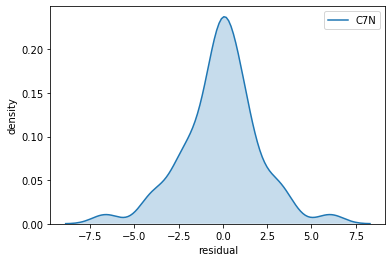

In [29]:
sns.kdeplot(residual[y_name],shade=True)
plt.xlabel('residual')
plt.ylabel('density')

# plot loss

In [0]:
plot_data = X_test[features]
plot_data['index'] = plot_data.index
plot_data[y_name] = y_test[y_name]
plot_data[y_name+'_pred'] = y_pred[y_name]
plot_data['loss'] = loss[y_name]
hover_data = plot_data.columns.tolist()

In [25]:
fig = px.scatter(plot_data,x=y_name,y="loss",color="loss",size="loss",hover_data=hover_data,text='index')
fig.show()

# find high loss sample

In [26]:
high_loss_index = plot_data['loss'].sort_values(ascending=False).index
print(high_loss_index[:10])

Int64Index([62, 66, 8, 88, 135, 3, 22, 57, 243, 27], dtype='int64')


# higlight the maxloss sample

In [0]:
higlight_index = high_loss_index[0]
pred_like_index = list(abs(plot_data[y_name+'_pred'] - plot_data.loc[higlight_index,y_name+'_pred']).sort_values().index[1:2])
test_like_index = list(abs(plot_data[y_name] - plot_data.loc[higlight_index,y_name]).sort_values().index[1:2])

# 觀察兩筆

,IBP,T10,T50,T90,EBP,N+A,T10-IBP,T50-T10,T90-T50,EBP-T90,index,C7N,C7N_pred,loss
62,8372.25,11046,12973.2,18933.8,26765,3643.14,184.96,77.44,561.69,676,62,29.3541,22.7297,6.62433
122,8299.21,10282,12656.2,20851.4,28594.8,3447.16,106.09,123.21,1017.61,610.09,122,22.9604,22.2578,0.702548


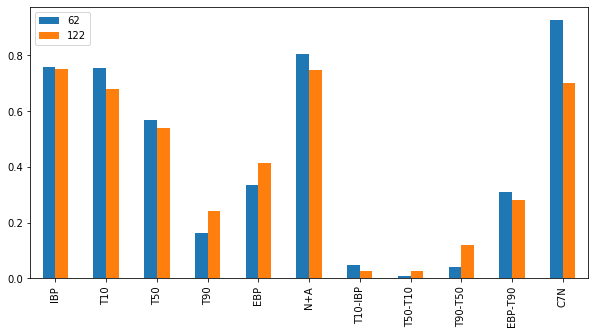

In [28]:
# prepare data
compare_data = plot_data.loc[[higlight_index]+pred_like_index]

# scaler for bar plot
scaler_bar = MinMaxScaler()
full = X.join(y)
full[features+[y_name]] = scaler_bar.fit_transform(full[features+[y_name]])
full.loc[compare_data.index,features+[y_name]].T.plot(kind='bar',figsize=(10,5))

# inver scaler for compare table
if scaler_x != None:
  compare_data[features] = scaler_x.inverse_transform(compare_data[features])

#show table
compare_data.style.background_gradient(axis=1)